# Modelo RFM

#### Librerias

In [1]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')
#from shapely.geometry import shape, Point
from plotnine import *
# instalar en la console terminal 
# pip install shapely
# conda install -y -c conda-forge plotnine


# Preprocesado y modelado
# ==============================================================================
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import pairwise_distances_argmin_min
import seaborn as sns
from datetime import datetime


import json
from scipy import stats

In [2]:
#pip install pyodbc

In [3]:
#conda install -y -c conda-forge plotnine

In [4]:
import pyodbc 
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=SRVDWHBI;'
                      'Database=DWH;'
                      'Trusted_Connection=yes;')

cursor = conn.cursor()

ventas = pd.read_sql_query("""SELECT FACT.id_persona, recencia = (datediff(day, max(fec.des_fecha), getdate())), 
                        frecuencia = count(distinct convert(varchar(10), id_almacen) + num_documento),
                        prom_venta_total = sum(monto_venta_pf )/count(distinct convert(varchar(10), id_almacen) + num_documento)
                        FROM DWH..dw_detalle_venta_fact FACT (NOLOCK) 
                        left join DWH..dw_tiempo_dim Fec (NOLOCK) on (FACT.id_fecha = Fec.id_fecha)    
                        left join DWH..dw_persona_dim p (NOLOCK) on (FACT.id_persoba = p.id_persona)
                        left join DWH..dw_producto_dim PROD(nolock) on (PROD.cod_producto=FACT.cod_producto) 
                        where FACT.id_fecha BETWEEN  20150101 AND 20211231
                        and prod.cod_grupo not in ('ST','SX') 
                        AND FACT.id_empresa in (3,5,7,8,9,15)
                        and prod.cod_linea not in ('LS','PR','MN','RR','RM','9999','MU','5637144584','JC','5637144831','GN','LC','RW','OT')
                        and monto_venta_pf>=0
                        and len(num_identificacion) = 10
                        and fact.id_persona <> 1176225
                        GROUP BY  FACT.id_persona""",conn)


#### Dataset

In [5]:
#ventas = pd.read_csv ('data_ventas.csv', delimiter=';')

In [6]:
ventas.head()

,id_persona,recencia,frecuencia,prom_venta_total
0,25660,1271,2,617.960
1,890882,1705,1,1675.680
2,543598,872,10,869.865
3,376857,795,4,801.210
4,983869,619,3,481.720


In [7]:
# Estadistica descriptiva del dataset
ventas.describe()

,id_persona,recencia,frecuencia,prom_venta_total
count,5.211870e+05,521187.000000,521187.000000,521187.000000
mean,1.080149e+06,931.850384,2.099224,681.022316
std,8.421580e+05,648.162559,3.528082,496.180152
min,5.000000e+00,1.000000,1.000000,0.000000
25%,4.345115e+05,394.000000,1.000000,347.080714
50%,8.698610e+05,829.000000,1.000000,590.160000
75%,1.301212e+06,1314.000000,2.000000,913.470000
max,3.043114e+06,2434.000000,1692.000000,36671.570000


In [8]:
ventas.dtypes

id_persona            int64
recencia              int64
frecuencia            int64
prom_venta_total    float64
dtype: object

#### Limpieza del Dataset

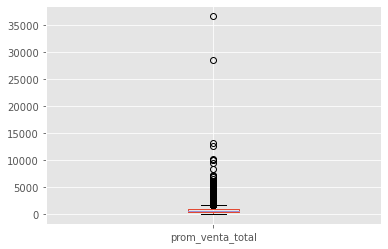

In [9]:
# Deteccion de ouliers Venta Total
ventas["prom_venta_total"].describe()
boxplot = ventas.boxplot(column=['prom_venta_total'])

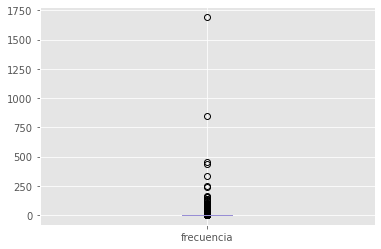

In [10]:
# Deteccion de ouliers Unidades Vendidas
ventas["frecuencia"].describe()
boxplot = ventas.boxplot(column=['frecuencia'])

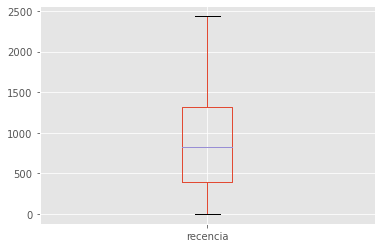

In [11]:
ventas["recencia"].describe()
boxplot = ventas.boxplot(column=['recencia'])

In [12]:
# Filtro excluyendo los ouliers - Prom_Venta_total
ventas = ventas[(ventas['prom_venta_total']> 0) & (ventas['prom_venta_total']<= 8000)]

# Filtro excluyendo los ouliers - frecuencia
ventas = ventas[(ventas['frecuencia']> 0) & (ventas['frecuencia']<= 150)]
 

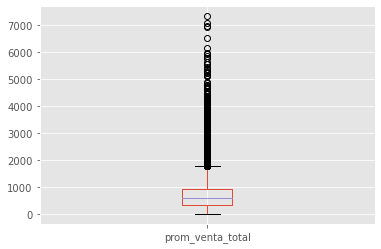

In [13]:
boxplot = ventas.boxplot(column=['prom_venta_total'])

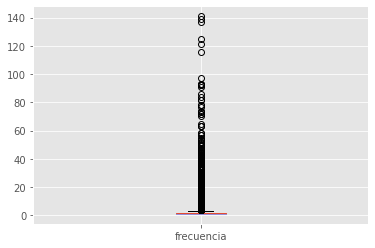

In [14]:
boxplot = ventas.boxplot(column=['frecuencia'])

#### Analisis Exploratorio de los Datos

No handles with labels found to put in legend.


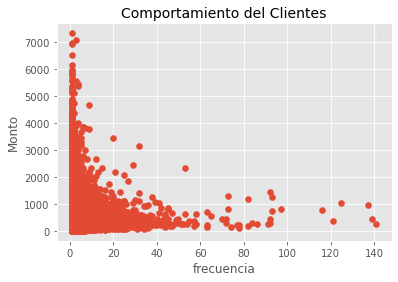

In [15]:
# Grafico del comportamiento de cliente(Frecuencia vs Monto de Compra)
plt.scatter(ventas['frecuencia'], ventas['prom_venta_total'])
plt.xlabel('frecuencia',fontsize=12)
plt.ylabel('Monto',fontsize=12)
plt.title('Comportamiento del Clientes',fontsize=14)
plt.grid(True)
plt.legend()

No handles with labels found to put in legend.


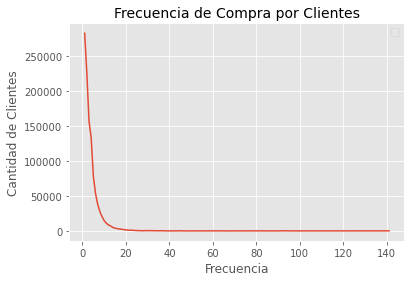

In [16]:
# Cuantas Veces Compran los Clientes?
frec=ventas.groupby("frecuencia").agg({"frecuencia":"sum"})
plt.plot(frec)
plt.xlabel('Frecuencia',fontsize=12)
plt.ylabel('Cantidad de Clientes',fontsize=12)
plt.title('Frecuencia de Compra por Clientes',fontsize=14)
plt.grid(True)
plt.legend()

No handles with labels found to put in legend.


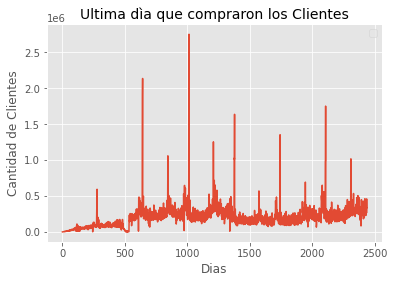

In [17]:
# Cuando fue la ultima vez que compraron los Clientes?
dias=ventas.groupby("recencia").agg({"recencia":"sum"})
plt.plot(dias)
plt.xlabel('Dias',fontsize=12)
plt.ylabel('Cantidad de Clientes',fontsize=12)
plt.title('Ultima dìa que compraron los Clientes',fontsize=14)
plt.grid(True)
plt.legend()

#### MODELO RFM

In [18]:
##Frecuencia, Promedio de ventas y Recencia por Cliente.

In [19]:
# seleccionamos las variables para el modelo RFM
RFM_Segment =ventas[['id_persona','prom_venta_total','recencia','frecuencia']]
# Renombramos las columnas de la tabla rfm
RFM_Segment.columns = ['id_persona', 'Monetary', 'Recency', 'Frequency']

In [20]:
quantiles = RFM_Segment.quantile(q=[0.25,0.5,0.75])
quantiles

,id_persona,Monetary,Recency,Frequency
0.25,434529.0,347.202500,394.0,1.0
0.50,869890.0,590.220000,828.0,1.0
0.75,1301243.5,913.496666,1314.0,2.0


In [21]:
# Converting quantiles to a dictionary, easier to use.
##  RFM Segmentation ----
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def R_Class(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
    
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FM_Class(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
RFM_Segment['R'] = RFM_Segment['Recency'].apply(R_Class, args=('Recency',quantiles,))
RFM_Segment['F'] = RFM_Segment['Frequency'].apply(FM_Class, args=('Frequency',quantiles,))
RFM_Segment['M'] = RFM_Segment['Monetary'].apply(FM_Class, args=('Monetary',quantiles,))
RFM_Segment['RFM_Score'] = RFM_Segment.R.map(str) \
                            + RFM_Segment.F.map(str) \
                            + RFM_Segment.M.map(str)

<ipython-input-21-bb6872a752bb>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-21-bb6872a752bb>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-21-bb6872a752bb>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-21-bb6872a752

In [22]:
RFM_Segment.head()

,id_persona,Monetary,Recency,Frequency,R,F,M,RFM_Score
0,25660,617.960,1271,2,2,3,3,233
1,890882,1675.680,1705,1,1,1,4,114
2,543598,869.865,872,10,2,4,3,243
3,376857,801.210,795,4,3,4,3,343
4,983869,481.720,619,3,3,4,2,342


In [23]:
# descriptivo
RFM_Segment.describe().T

,count,mean,std,min,25%,50%,75%,max
id_persona,521111.0,1.080199e+06,842184.264429,5.00,434529.0000,869890.00,1.301244e+06,3043114.00
Monetary,521111.0,6.808400e+02,490.763590,1.78,347.2025,590.22,9.134967e+02,7316.02
Recency,521111.0,9.317282e+02,648.045983,1.00,394.0000,828.00,1.314000e+03,2434.00
Frequency,521111.0,2.090303e+00,2.065915,1.00,1.0000,1.00,2.000000e+00,141.00
R,521111.0,2.500688e+00,1.118017,1.00,2.0000,3.00,4.000000e+00,4.00
F,521111.0,2.160129e+00,1.304688,1.00,1.0000,1.00,3.000000e+00,4.00
M,521111.0,2.499999e+00,1.118036,1.00,1.5000,2.00,3.500000e+00,4.00


In [24]:
RFM_Segment['score'] = RFM_Segment[['R','F','M']].sum(axis=1)

<ipython-input-24-1d23e6a915b7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [25]:
# ## Customer segments with RFM Model
# # Segment customers based on RFM score
# 3 - 7 - Low valued customer
# 7 - 9 - Medium valued customer
# 9 - 12 - High valued customer
def segment(df):
    if df['score'] >= 9:
        return '1.High Value Customer'
    elif (df['score'] >= 7) and (df['score'] < 9):
        return '2.Medium Value Customer'
    else:
        return '3.Low value Customer'

In [26]:
RFM_Segment['segment'] = RFM_Segment.apply(segment, axis=1)

<ipython-input-26-5c817fa9845a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [27]:
## Segmentacion de cliente
print("Best Customers: ",len(RFM_Segment[RFM_Segment['RFM_Score']=='444']))
print('Loyal Customers: ',len(RFM_Segment[RFM_Segment['F']==4]))
print("Big Spenders: ",len(RFM_Segment[RFM_Segment['M']==4]))
print('Almost Lost: ', len(RFM_Segment[RFM_Segment['RFM_Score']=='244']))
print('Lost Customers: ',len(RFM_Segment[RFM_Segment['RFM_Score']=='144']))
print('Lost Cheap Customers: ',len(RFM_Segment[RFM_Segment['RFM_Score']=='111']))

Best Customers:  5177
Loyal Customers:  126430
Big Spenders:  130278
Almost Lost:  5669
Lost Customers:  4371
Lost Cheap Customers:  20698


In [28]:
#Mejores
#RFMClass = 444
RFM_Segment[RFM_Segment['RFM_Score']=='444'].sort_values('Monetary', ascending=False).head()

,id_persona,Monetary,Recency,Frequency,R,F,M,RFM_Score,score,segment
41790,2769934,7067.466666,246,3,4,4,4,444,12,1.High Value Customer
506070,2574078,5558.863333,172,3,4,4,4,444,12,1.High Value Customer
445621,392581,4677.504444,235,9,4,4,4,444,12,1.High Value Customer
242895,137827,3440.905500,40,20,4,4,4,444,12,1.High Value Customer
520051,7257,3181.772000,289,5,4,4,4,444,12,1.High Value Customer


In [29]:
#En Riesgo
#Customers who's recency value is low
RFM_Segment[RFM_Segment['R'] <= 2 ].sort_values('Monetary', ascending=False).head(5)

,id_persona,Monetary,Recency,Frequency,R,F,M,RFM_Score,score,segment
11582,1086436,7316.02,1713,1,1,1,4,114,6,3.Low value Customer
492028,1038346,5955.43,1177,1,2,1,4,214,7,2.Medium Value Customer
254685,797230,5912.83,1064,1,2,1,4,214,7,2.Medium Value Customer
465069,269154,5862.15,1750,1,1,1,4,114,6,3.Low value Customer
122758,948754,5617.71,1163,1,2,1,4,214,7,2.Medium Value Customer


In [36]:
#Perdidos
#Customers who's recency, frequency as well as monetary values are low 
RFM_Segment[RFM_Segment['RFM_Score']=='111'].sort_values('Recency',ascending=False).head(5)

,id_persona,Monetary,Recency,Frequency,R,F,M,RFM_Score,score,segment
423741,638290,160.51,2434,1,1,1,1,111,3,3.Low value Customer
315124,1160985,121.44,2434,1,1,1,1,111,3,3.Low value Customer
171864,41889,33.89,2434,1,1,1,1,111,3,3.Low value Customer
506394,973428,273.30,2434,1,1,1,1,111,3,3.Low value Customer
60800,1254400,71.96,2434,1,1,1,1,111,3,3.Low value Customer


In [37]:
#Leales
#Customers with high frequency value
RFM_Segment[RFM_Segment['F'] >= 3 ].sort_values('Monetary', ascending=False).head(5)

,id_persona,Monetary,Recency,Frequency,R,F,M,RFM_Score,score,segment
423210,2213784,12605.190000,602,4,3,4,4,344,11,1.High Value Customer
74431,555858,10023.811666,210,6,4,4,4,444,12,1.High Value Customer
349167,768792,8347.520000,848,2,2,3,4,234,9,1.High Value Customer
40536,2769934,7067.466666,246,3,4,4,4,444,12,1.High Value Customer
466134,2574078,5558.863333,172,3,4,4,4,444,12,1.High Value Customer


In [38]:
# Resumen del modelo RFM
RFM_Segment[["segment","Recency","Frequency","Monetary"]].groupby("segment").agg(["mean","median","count"]).sort_values(by = 'segment', ascending = True)

Recency                Frequency                 \
                                mean median   count      mean median   count   
segment                                                                        
1.High Value Customer     503.245682    380  147113  3.565409      3  147113   
2.Medium Value Customer   911.280294    837  166147  1.978537      2  166147   
3.Low value Customer     1251.301121   1201  207863  1.140251      1  207863   

                           Monetary                  
                               mean  median   count  
segment                                              
1.High Value Customer    858.839219  786.65  147113  
2.Medium Value Customer  807.522308  676.42  166147  
3.Low value Customer     453.942368  347.31  207863

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


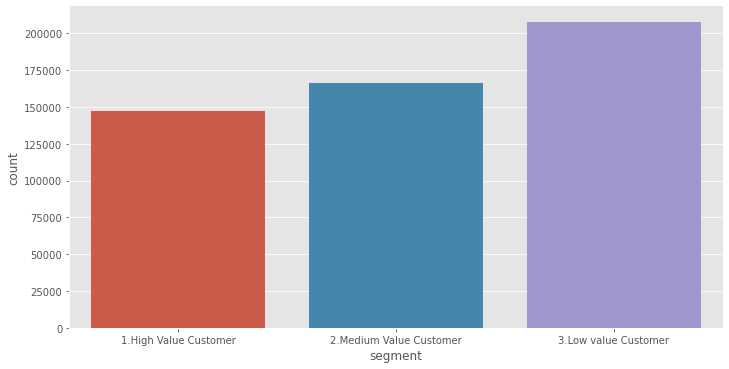

In [39]:
# Cantidad de Clientes Buenos vs Malos
sns.factorplot('segment',data=RFM_Segment,kind="count",size=5, aspect=2  )
# Se evidencia data balanceada

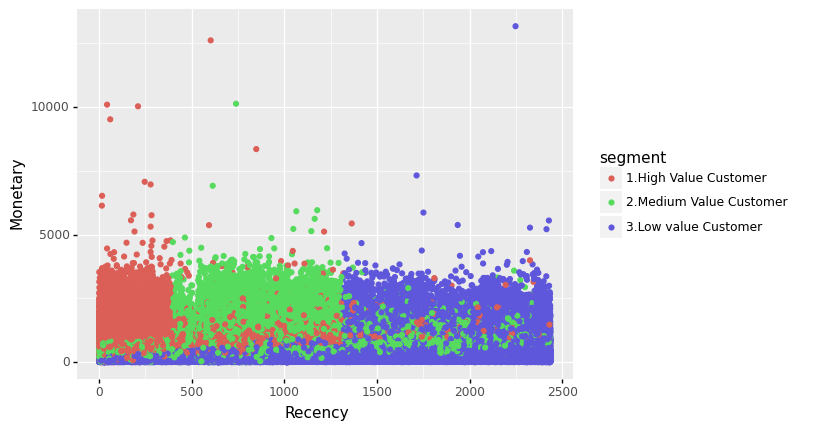

<ggplot: (93482439036)>

In [40]:
# Grafico de Segmentos de clientes Buenos vs Malos
ggplot(RFM_Segment, aes(x='Recency', y='Monetary', 
    color = 'segment')) + geom_point()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.


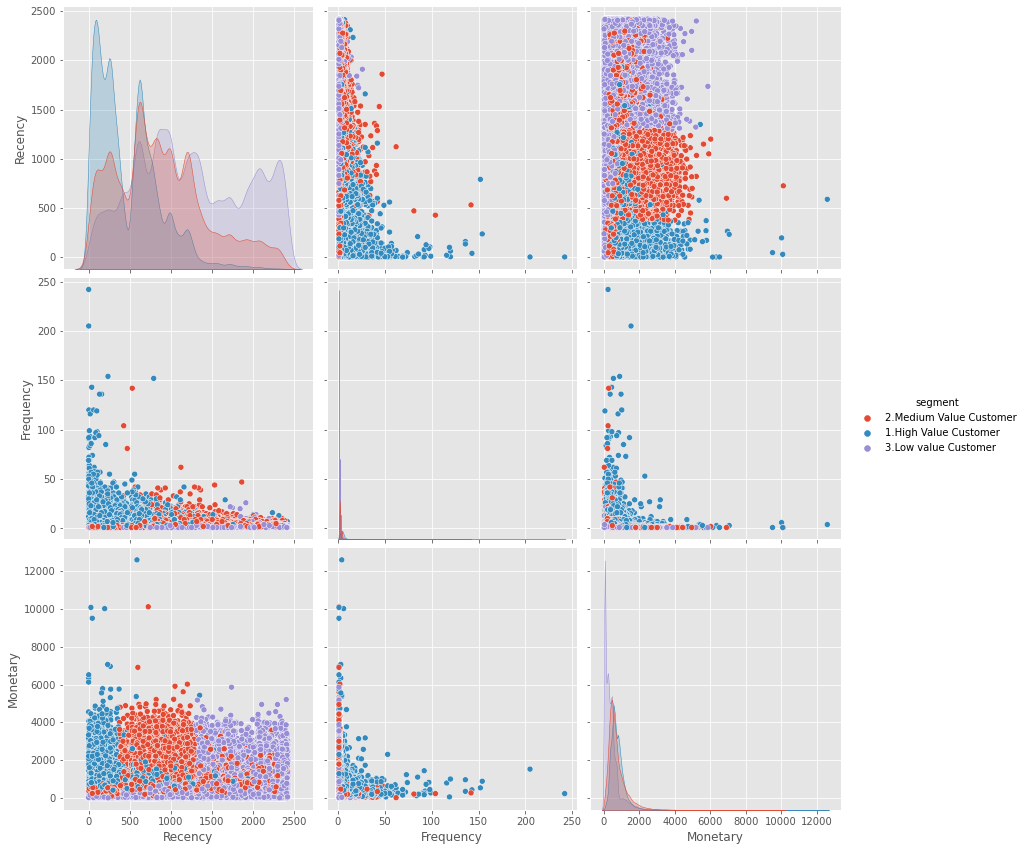

In [158]:
# correlacion entre Recency, Frecuency y Monetary
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
sns.pairplot(RFM_Segment.dropna(), hue='segment',size=4,vars=["Recency","Frequency","Monetary"],kind='scatter')

In [30]:
RFM_Segment.to_csv('rfm.csv')
###correr hasta aqui

In [30]:
#pip install urllib3

In [86]:
#pip install pypyodbc

In [87]:
#pip install sqlalchemy

In [48]:
import sqlalchemy

server = 'SRVDWHBI' 
database = 'STAGING' 
username = 'userssis' 
password = 'Pa$$w0rd' 
driver = '{SQL Server}'
test = 'TEMP_RFM_CLIENTE'
params = 'DRIVER='+ driver + ';SERVER='+server + ';PORT=1433;DATABASE=' + database + ';UID=' + username + ';PWD=' + password
#df_op is the dataframe that needs to be written to database and test is the table name in database and col_name1, col_name2,... are the respective column names
cnxn = pypyodbc.connect(params)
cursor = cnxn.cursor()
cursor.execute("TRUNCATE TABLE TEMP_RFM_CLIENTE")

db_params = urllib.parse.quote_plus(params)
engine = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect={}".format(db_params))
#df is the dataframe; test is table name in which this dataframe is #inserted
RFM_Segment.to_sql(test,engine,index=False,if_exists="append",schema="dbo")

OperationalError: (pyodbc.OperationalError) ('08S01', '[08S01] [Microsoft][ODBC SQL Server Driver]Error en el vínculo de comunicación (0) (SQLEndTran)')
(Background on this error at: http://sqlalche.me/e/14/e3q8)

In [85]:
import pyodbc
import contextlib

server = 'SRVDWHBI' 
database = 'STAGING' 
username = 'userssis' 
password = 'Pa$$w0rd' 
driver = '{SQL Server}' 
params = 'DRIVER='+ driver + ';SERVER='+server + ';PORT=1433;DATABASE=' + database + ';UID=' + username + ';PWD=' + password
#df_op is the dataframe that needs to be written to database and test is the table name in database and col_name1, col_name2,... are the respective column names
 
cnxn = pyodbc.connect(params)
crsr = cnxn.cursor()
sql = """
FROM 'rfm.csv' 
WITH
(  FIELDTERMINATOR = ','
)
"""
crsr.execute(sql)
cnxn.commit()
crsr.close()
cnxn.close()

ProgrammingError: ('42000', "[42000] [Microsoft][ODBC SQL Server Driver][SQL Server]Incorrect syntax near the keyword 'FROM'. (156) (SQLExecDirectW)")